# Exercise06 : Experimentation Logs and Outputs

Here we add logging capabilities in our source code, and check the collected logs and metrics.

*back to [index](https://github.com/tsmatz/azureml-tutorial/)*

## Get workspace setting

In [1]:
from azureml.core import Workspace
import azureml.core

ws = Workspace.from_config()

## Create experiment

In [2]:
from azureml.core import Experiment

experiment = Experiment(workspace=ws, name='test_experiment')

## Start experiment run

In [3]:
run = experiment.start_logging()

## Change your source code and Train

Change your source code in "[Exercise03 : Just Train in Your Working Machine](./exercise03_train_simple.ipynb)" for logging in AML as follows. (The lines commented "##### Modified" are modified lines.)<br>
After running, let's go to [AML Studio](https://ml.azure.com/) and see how logs look like in AML jobs.

In [5]:
import os
import argparse
import tensorflow as tf

from azureml.core.run import Run ##### Modified

# Get run when running in remote ##### Modified
if 'run' not in locals(): ##### Modified
    run = Run.get_context() ##### Modified

# parse arguments
parser = argparse.ArgumentParser()
parser.add_argument(
    "--data_folder",
    type=str,
    default="./data",
    help="Folder path for input data")
parser.add_argument(
    "--model_folder",
    type=str,
    default="./outputs",  # AML experiments outputs folder
    help="Folder path for model output")
parser.add_argument(
    "--learning_rate",
    type=float,
    default="0.001",
    help="Learning Rate")
parser.add_argument(
    "--first_layer",
    type=int,
    default="128",
    help="Neuron number for the first hidden layer")
parser.add_argument(
    "--second_layer",
    type=int,
    default="64",
    help="Neuron number for the second hidden layer")
parser.add_argument(
    "--epochs_num",
    type=int,
    default="6",
    help="Number of epochs")
FLAGS, unparsed = parser.parse_known_args()

# build model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(FLAGS.first_layer, activation="relu"),
    tf.keras.layers.Dense(FLAGS.second_layer, activation="relu"),
    tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(FLAGS.learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Create custom callback ##### Modified
class CustomOutputCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Note : Use log_list() instead of calling a lot of times.
        run.log('training_accuracy', logs["sparse_categorical_accuracy"])
        run.log('training_loss', logs["loss"])
    def on_train_end(self, logs=None):
        run.log('final_accuracy', logs["sparse_categorical_accuracy"])
        run.log('final_loss', logs["loss"])

# run training
train_data_path = os.path.join(FLAGS.data_folder, "train")
train_data = tf.data.experimental.load(train_data_path)
model.fit(
    train_data.shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE),
    epochs=FLAGS.epochs_num,
    callbacks=[CustomOutputCallback()]  ##### Modified
)

# save model and variables
model_path = os.path.join(FLAGS.model_folder, "mnist_tf_model")
model.save(model_path)
print("current working directory : ", os.getcwd())
print("model folder : ", model_path)

# send logs to AML ##### Modified   
run.log('learning_rate', FLAGS.learning_rate) ##### Modified
run.log('1st_layer', FLAGS.first_layer) ##### Modified
run.log('2nd_layer', FLAGS.second_layer) ##### Modified

Epoch 1/6
469/469 [==============================] - 2s 4ms/step - loss: 2.7900 - sparse_categorical_accuracy: 0.8467
Epoch 2/6
469/469 [==============================] - 2s 4ms/step - loss: 0.5005 - sparse_categorical_accuracy: 0.9239
Epoch 3/6
469/469 [==============================] - 2s 4ms/step - loss: 0.2859 - sparse_categorical_accuracy: 0.9422
Epoch 4/6
469/469 [==============================] - 2s 5ms/step - loss: 0.1986 - sparse_categorical_accuracy: 0.9547
Epoch 5/6
469/469 [==============================] - 2s 4ms/step - loss: 0.1604 - sparse_categorical_accuracy: 0.9607
Epoch 6/6
469/469 [==============================] - 2s 4ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.9639
INFO:tensorflow:Assets written to: ./outputs/mnist_tf_model/assets
current working directory :  /home/tsmatsuz/python_sdk1
model folder :  ./outputs/mnist_tf_model


## Stop Run

In [6]:
run.complete()

## Show logs using AML run history widget

You can view detailed logs on "Experiments" in Azure Machine Learning studio UI (https://ml.azure.com/).

You can also view your logs in your working notebook as follows. (For viewing in notebook, you must install widgets extensions. See [readme](https://github.com/tsmatz/azureml-tutorial/) for extension installation.)

In [7]:
from azureml.widgets import RunDetails
RunDetails(run_instance=run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## Plot by code

You can also explorer using python code and plot as you like.

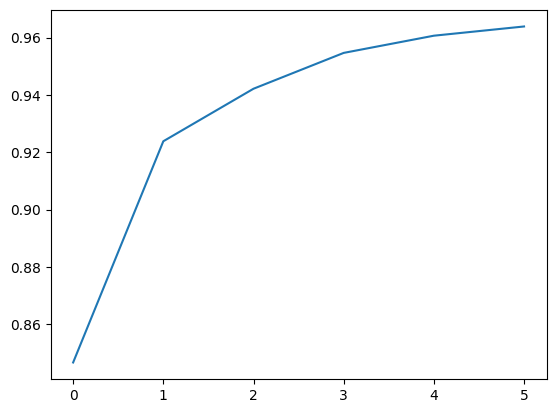

In [8]:
import matplotlib.pyplot as plt
metrics = run.get_metrics()
plt.plot(metrics['training_accuracy'])